In [1]:
import pandas as pd

# Load the datasets
supplier_profiles = pd.read_csv('supplier_profiles.csv')
evaluation_criteria = pd.read_csv('evaluation_criteria.csv')
procurement_requirements = pd.read_csv('procurement_requirements.csv')
supplier_performance = pd.read_csv('supplier_performance.csv')

# Displaying the first few rows of each dataset to understand their structure
supplier_profiles_head = supplier_profiles.head()
evaluation_criteria_head = evaluation_criteria.head()
procurement_requirements_head = procurement_requirements.head()
supplier_performance_head = supplier_performance.head()

supplier_profiles_head, evaluation_criteria_head, procurement_requirements_head, supplier_performance_head


(  Supplier_ID          Supplier_Name          Category Location  \
 0      SUP001  Global Tech Solutions      IT Equipment      USA   
 1      SUP002     Eco Materials Inc.     Raw Materials  Germany   
 2      SUP003         FastSupply Co.         Logistics    India   
 3      SUP004    Quality Metal Works     Manufacturing    China   
 4      SUP005       Green Power Ltd.  Renewable Energy   Canada   
 
                Website  
 0   www.globaltech.com  
 1  www.ecomaterials.de  
 2    www.fastsupply.in  
 3  www.qualitymetal.cn  
 4    www.greenpower.ca  ,
   Criteria_ID            Criterion  Weightage
 0     CRIT001                 Cost       0.30
 1     CRIT002              Quality       0.25
 2     CRIT003       Delivery Speed       0.20
 3     CRIT004       Sustainability       0.15
 4     CRIT005  Technical Expertise       0.10,
   Requirement_ID                                        Description  \
 0         REQ001  Looking for a reliable supplier for IT hardwar...   
 1    

In [2]:
# Merge datasets based on relationships
# Supplier profiles linked to performance
supplier_data = pd.merge(supplier_profiles, supplier_performance, on="Supplier_ID", how="inner")

# Supplier data linked to procurement requirements (by Category)
supplier_requirements = pd.merge(supplier_data, procurement_requirements, on="Category", how="inner")

# View the integrated dataset
supplier_requirements.head()


,Supplier_ID,Supplier_Name,Category,Location,Website,On_Time_Delivery_Rate,Average_Cost,Quality_Score,Sustainability_Score,Requirement_ID,Description,Deadline
0,SUP001,Global Tech Solutions,IT Equipment,USA,www.globaltech.com,0.95,1000,4.5,3.8,REQ001,Looking for a reliable supplier for IT hardwar...,2024-12-15
1,SUP002,Eco Materials Inc.,Raw Materials,Germany,www.ecomaterials.de,0.90,800,4.7,4.9,REQ002,Seeking eco-friendly raw materials for product...,2025-01-10
2,SUP003,FastSupply Co.,Logistics,India,www.fastsupply.in,0.85,950,4.2,3.5,REQ003,Need logistics partner for international shipm...,2024-11-30
3,SUP004,Quality Metal Works,Manufacturing,China,www.qualitymetal.cn,0.80,1200,4.3,3.2,REQ004,High-quality metal components for automotive a...,2024-12-20
4,SUP005,Green Power Ltd.,Renewable Energy,Canada,www.greenpower.ca,0.98,1050,4.8,5.0,REQ005,Solar panels and wind turbines for renewable e...,2025-02-01


In [3]:
# Load evaluation criteria weights
criteria_weights = evaluation_criteria.set_index("Criterion")["Weightage"].to_dict()

# Composite score calculation
supplier_requirements["Composite_Score"] = (
    supplier_requirements["On_Time_Delivery_Rate"] * criteria_weights.get("Delivery Speed", 0) +
    supplier_requirements["Quality_Score"] * criteria_weights.get("Quality", 0) +
    supplier_requirements["Sustainability_Score"] * criteria_weights.get("Sustainability", 0) +
    (1000 / supplier_requirements["Average_Cost"]) * criteria_weights.get("Cost", 0)  # Cost as inverse
)

# Normalize scores to a percentage scale
supplier_requirements["Composite_Score"] = (
    supplier_requirements["Composite_Score"] / supplier_requirements["Composite_Score"].max() * 100
)

# Assign labels based on thresholds
def assign_label(score):
    if score >= 80:
        return "Approved"
    elif score >= 60:
        return "Pending"
    else:
        return "Rejected"

supplier_requirements["Evaluation_Label"] = supplier_requirements["Composite_Score"].apply(assign_label)

# Display updated dataset with target variable
supplier_requirements[["Supplier_ID", "Composite_Score", "Evaluation_Label", "Description"]].head()


,Supplier_ID,Composite_Score,Evaluation_Label,Description
0,SUP001,88.640974,Approved,Looking for a reliable supplier for IT hardwar...
1,SUP002,100.000000,Approved,Seeking eco-friendly raw materials for product...
2,SUP003,83.602007,Approved,Need logistics partner for international shipm...
3,SUP004,79.716024,Pending,High-quality metal components for automotive a...
4,SUP005,98.649667,Approved,Solar panels and wind turbines for renewable e...


In [4]:
!pip install transformers


In [5]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize textual data (Descriptions)
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

# Encode labels to numeric
label_mapping = {"Approved": 0, "Pending": 1, "Rejected": 2}
supplier_requirements["Label"] = supplier_requirements["Evaluation_Label"].map(label_mapping)

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    supplier_requirements["Description"],
    supplier_requirements["Label"],
    test_size=0.2,
    random_state=42
)

# Tokenize train and test data
train_encodings = tokenize_texts(train_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

# Display a sample of tokenized training data
train_encodings.data.keys(), train_encodings["input_ids"][:2], train_labels.head(2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(dict_keys(['input_ids', 'token_type_ids', 'attention_mask']),
 tensor([[  101,  5943,  9320,  1998,  3612, 17396,  2005, 13918,  2943,  3934,
           1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0

In [5]:
!pip install torch torchvision torchaudio


In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW

# Define a custom dataset class for the tokenized data
class SupplierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

# Create train and test datasets
train_dataset = SupplierDataset(train_encodings, train_labels)
test_dataset = SupplierDataset(test_encodings, test_labels)

# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define DataLoader, optimizer, and loss function
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        # Move batch to device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# Save the trained model
model.save_pretrained("supplier_evaluation_bert_model")



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-1dab008da699>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/3, Loss: 1.0738
Epoch 2/3, Loss: 0.9505
Epoch 3/3, Loss: 0.7091


<ipython-input-6-1dab008da699>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifi

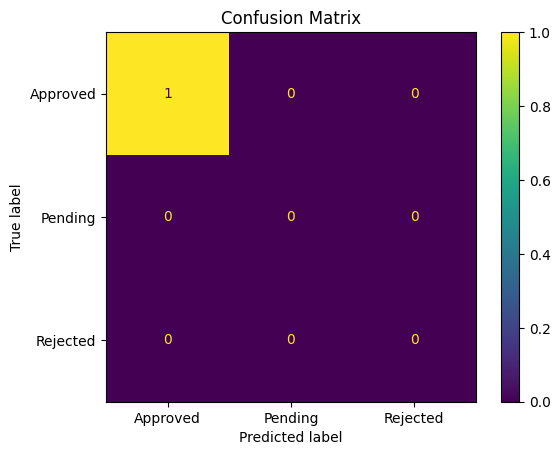

              precision    recall  f1-score  support
Approved       1.000000  1.000000  1.000000      1.0
Pending        0.000000  0.000000  0.000000      0.0
Rejected       0.000000  0.000000  0.000000      0.0
accuracy       1.000000  1.000000  1.000000      1.0
macro avg      0.333333  0.333333  0.333333      1.0
weighted avg   1.000000  1.000000  1.000000      1.0


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# Define the target labels explicitly
target_labels = [0, 1, 2]  # Corresponding to Approved, Pending, Rejected

# Generate classification report with specified labels
report = classification_report(
    all_labels,
    all_preds,
    target_names=["Approved", "Pending", "Rejected"],
    labels=target_labels,
    output_dict=True
)

# Confusion matrix and visualization
conf_matrix = confusion_matrix(all_labels, all_preds, labels=target_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Approved", "Pending", "Rejected"])

# Plot confusion matrix
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# Display classification metrics
import pandas as pd
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)
